In [1]:
import pandas as pd 
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr
import hydroeval as he 
import seaborn as sns 
from tqdm import tqdm 

In [2]:
signature_dir = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\training_data_S1\signatures_nc_V1_output") 
 
fn_signatures = signature_dir / "S1_merged_signatures_v2-cleanup-1.csv"
# fn_signatures = signature_dir / "S1_merged_signatures_v2-cleanup-2.csv" 

df_signatures = pd.read_csv(fn_signatures, index_col = 0)

df_signatures

,Nm-all,Ns-all,N-gof-all,Lm-all,Ls-all,L-gof-all,Gu-all,Ga-all,Gev-gof-all,Gk-all,...,flv-seasonal_1,hf-f-all,hf-f-seasonal_1,hf-t-all,lf-f-all,lf-f-seasonal_1,lf-t-seasonal_1,pks-all,tag,dem_flag
ID,,,,,,,,,,,,,,,,,,,,,
6119010_11,102.035362,106.090645,0.0,4.221500,0.863208,0.0,54.306767,0.012089,0.0,0.925012,...,164.721008,0.590909,0.0,2.954545,0.363636,0.636364,4.481481,666.803894,6119010,0
6119010_12,100.917046,105.168777,0.0,4.209119,0.864435,0.0,53.603184,0.012195,0.0,0.920779,...,163.700439,0.590909,0.0,3.090909,0.363636,0.636364,4.518519,654.762268,6119010,0
6119010_13,0.544169,0.542255,0.0,-1.002645,0.867551,0.0,0.300217,2.365214,0.0,1.007072,...,266.693390,0.409091,0.0,1.727273,0.409091,0.636364,6.000000,3.131104,6119010,0
6119010_14,162.321777,138.910507,0.0,4.760090,0.835850,0.0,99.828016,0.009233,0.0,1.365474,...,317.679565,0.045455,0.0,0.136364,1.000000,0.545455,7.227273,723.082581,6119010,0
6119010_15,17.163115,16.641987,0.0,2.442999,0.888787,0.0,9.676133,0.077067,0.0,1.063609,...,248.398575,0.136364,0.0,0.363636,0.454545,0.500000,6.083333,98.092957,6119010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6983350_96,522.018127,325.349060,0.0,6.080506,0.592225,0.0,375.648448,0.003942,0.0,2.574376,...,60.206692,0.000000,0.0,0.000000,0.111111,0.000000,0.000000,1890.435181,6983350,0
6983350_97,1.769354,1.644365,0.0,0.271318,0.743112,0.0,1.029579,0.779967,0.0,1.157798,...,73.878761,0.333333,0.0,1.000000,0.111111,0.555556,6.181818,10.525513,6983350,0
6983350_98,6.406629,5.884712,0.0,1.530997,0.797030,0.0,3.759185,0.217946,0.0,1.185247,...,92.737022,0.444444,0.0,1.000000,0.444444,0.444444,4.800000,33.151855,6983350,0


In [3]:
## TO DO 
## - scale values in overview plotter - try for all the same ?

In [4]:
## expand searching area by max. 2 pixels 

def expand_labels(df, id_col, target_col, critical_variable, 
                  p_diff = 5., n_max = 3, pixel_size = 5000., option = 1,
                  x_coord = 'x', y_coord = 'y'):
    
    out_col = 'range_{}'.format(target_col)
    df[out_col] = 0.
    
    for bix in df[id_col].unique():
        
        ## select buffer and target value 
        _buffer = df[ df[id_col] == bix ] 
        
        ## discard gauge values 
        buffer_ix = [ix for ix in _buffer.index if not 'gauge' in ix]
        _sim = _buffer.loc[buffer_ix] 
        
        ## select target row 
        target = _sim[ _sim[target_col] == 1.]
        
        ## if target value found
        if len(target) > 0:
            
            ## search criterium 
            target_var = target[critical_variable].values[0] 
            
            ## look to adjacent pixels only 
            target_X_coord = target[x_coord].values[0]
            target_Y_coord = target[y_coord].values[0] 
            x_filter = (_sim[x_coord] >= target_X_coord - (pixel_size+1.) ) & (_sim[x_coord] <= target_X_coord + (pixel_size+1.))
            y_filter = (_sim[y_coord] >= target_Y_coord - (pixel_size+1.) ) & (_sim[y_coord] <= target_Y_coord + (pixel_size+1.))
            _sim = _sim[ x_filter & y_filter]

            ## calculate absolute percentual difference 
            d_var = (( ((_sim[critical_variable] - target_var)**2)**0.5 / target_var)*100 ).sort_values()
            
            ## OPTION 1 - select top three (including original target pixel) based on difference 
            if option == 1:
                expand_targets = d_var.head(n_max).index 

            ## OPTION 2 - also include a percentual limit (1% - 5%) 
            if option == 2:
                expand_targets = d_var[ d_var <= p_diff].index
                if len(expand_targets) > n_max:
                    expand_targets = expand_targets[:int(n_max-1)]

            ## relabel 
            if target.index[0] in expand_targets:
                df.loc[expand_targets, out_col] = 1 
            else:
                print('check ', bix)            

    return df, out_col

df_signatures, range_col = expand_labels(df_signatures, 'tag', 'target', 'Nm-all', option = 1)#, p_diff = 1.) 

In [5]:
## column descriptors 
columns = df_signatures.columns.values 

## target value to predict 
target_col = ['target'] 

## should be omitted from dataset - but could be useful for easy selection 
## dem_flag only 1 for gauge values
non_feature_cols = ['n_buffer', 'tag', 'dem_flag', range_col] 

## coord cols - could be ommitted from dataset, risk for overfitting
## and also takes away focus on selection based on timeseries
coord_cols = ['x', 'y', 'lat', 'lon']

## features that do not have to be transformed by subtraction 
## and cross-correlation properties, that are already a similarity property 
## as they are cross-correlation values of simulations and observations
non_similarity_cols = [col for col in columns if 'clag' in col]

feature_cols = [col for col in columns if (col not in non_feature_cols) & (not 'target' in col)]

## if coord_cols ommitted:
omit_coords = True

if omit_coords:
    feature_cols = [col for col in feature_cols if col not in coord_cols] 

## columns on which to perform similarity calculations:
calc_cols = [col for col in feature_cols if col not in non_similarity_cols]

In [6]:
## depedentent on algorithm: check parameter distribution, transform to obtain a normal distribution

def plot_par(df, param = None):
    
    ## if no parameter specified, select a random parameter 
    if param == None:
        pars = df.columns 
        sample = np.random.randint(low=0, high= len(pars)-1 ) 
        param = pars[sample] 
    
    plt.figure(figsize=(3,3))
    plt.title(param)
    df[param].hist(bins=50)
    plt.yscale('log')


def plot_par_grid(df, nrows = 9, ncols = 9, y_log=False):

    plt.figure(figsize=(15,15))

    for i, col in enumerate(df.columns):
        plt.subplot(nrows, ncols, int(i+1))
        plt.title(col)
        df[col].hist(bins=50)
        
        if y_log:
            plt.yscale('log')
    
    plt.suptitle('Parameter histograms')
    plt.tight_layout()

def plot_2d_params(df, feature_cols, target_col, param_1 = None, param_2 = None):
    
    if param_1 not in feature_cols:
        sample = np.random.randint(low=0, high=len(feature_cols)-1)
        param_1 = feature_cols[sample]

    if param_2 not in feature_cols: 
        sample = np.random.randint(low=0, high=len(feature_cols)-1)
        param_2 = feature_cols[sample] 
    
    ## create a scatter plot with params 1 and 2
    ## labelled with target value 
    
    target_vals = df[target_col].unique() 
    
    plt.figure() 

    for t_val in target_vals:
        _df = df[ df[target_col] == t_val] 
        plt.plot( _df[param_1], _df[param_2], linestyle='none', marker = '.', label=f'{t_val}' )
    
    plt.legend()
    plt.xlabel(f'{param_1}')
    plt.ylabel(f'{param_2}')
    plt.yscale('log')
    plt.xscale('log')
    
def plot_2d_buffer(df, feature_cols, target_col, buffer_col, 
                   buffer_id = None, param_1 = None, param_2 = None):
        
    if param_1 not in feature_cols:
        sample = np.random.randint(low=0, high=len(feature_cols)-1)
        param_1 = feature_cols[sample]

    if param_2 not in feature_cols: 
        sample = np.random.randint(low=0, high=len(feature_cols)-1)
        param_2 = feature_cols[sample] 
    
    if buffer_id not in df[buffer_col].unique():
        sample = np.random.randint(low=0, high = df[buffer_col].nunique()-1)
        buffer_id = df[buffer_col].unique()[sample]
    
    ## create a scatter plot with params 1 and 2
    ## labelled with target value 
    
    df_buffer = df[ df[buffer_col] == buffer_id]
    target_vals = df_buffer[target_col].unique() 
    
    ix_obs = [ix for ix in df_buffer.index if 'gauge' in ix]
    ix_sim = [ix for ix in df_buffer.index if not 'gauge' in ix]
    
    
    plt.figure() 

    for t_val in target_vals:
        _df = df_buffer[ df[target_col] == t_val] 
        _df_obs = _df[ _df.index.isin(ix_sim) ]
        
        if t_val == 1.:
            plt.plot( _df_obs[param_1], _df[param_2], linestyle='none', marker = 'o', label=f'{t_val}' )
        else:
            plt.plot( _df_obs[param_1], _df_obs[param_2], linestyle='none', marker = '.', label=f'{t_val}' )
    
    if len(ix_obs) > 0:
        plt.plot( df_buffer.loc[ix_obs, param_1], df_buffer.loc[ix_obs, param_2], linestyle='none', marker = 'X', label='obs'  )
            
    plt.legend()
    plt.xlabel(f'{param_1}')
    plt.ylabel(f'{param_2}')
#     plt.yscale('log')
#     plt.xscale('log')
    plt.title(f'{buffer_id}')

In [7]:
# plot_2d_params(df_signatures, feature_cols, target_col[0])
# plot_2d_buffer(df_signatures, feature_cols, target_col[0], 'tag')

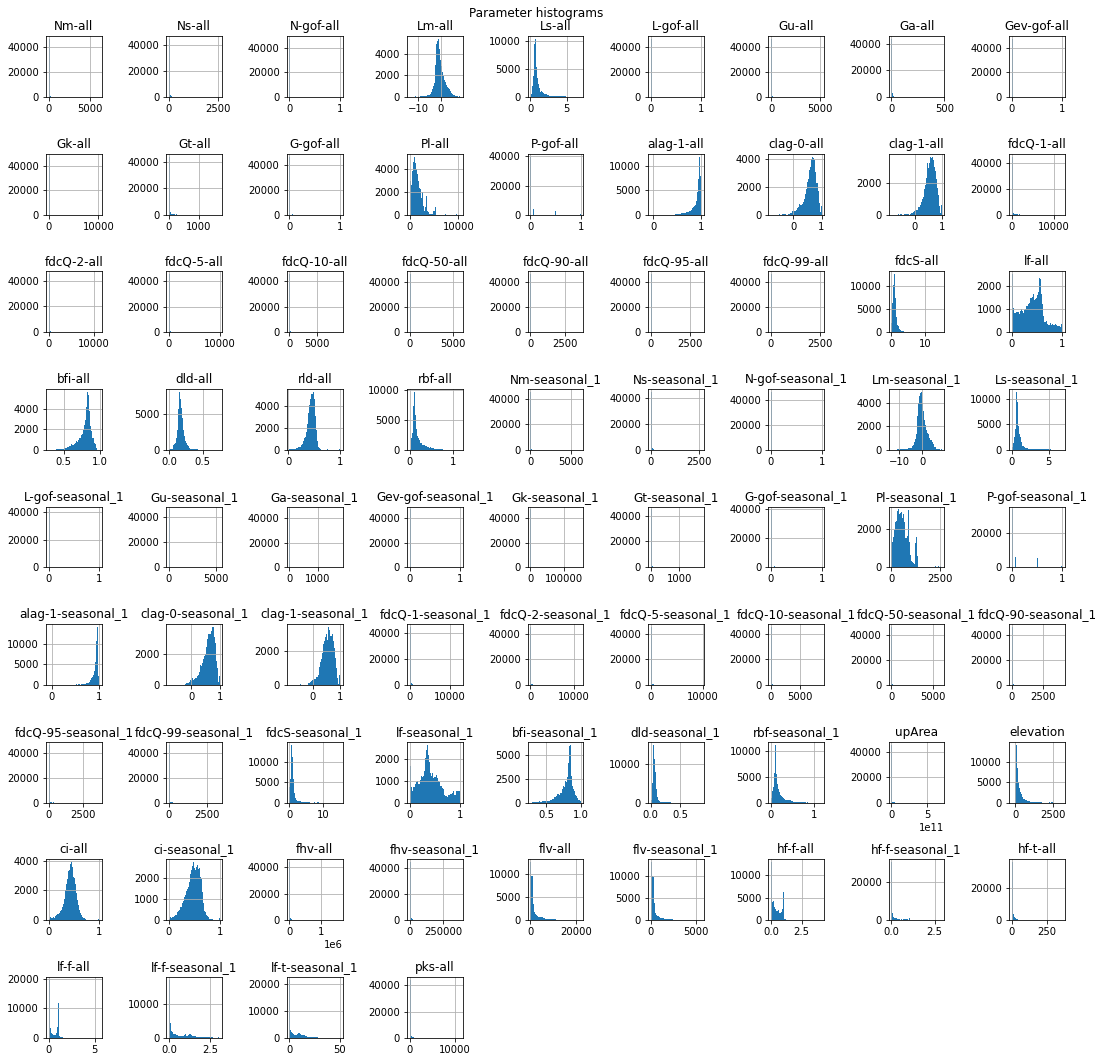

In [8]:
plot_cols = [col for col in df_signatures.columns if (col not in coord_cols) & (col not in non_feature_cols) & (not 'target' in col)]
plot_par_grid(df_signatures[plot_cols], nrows=9, ncols=9)

In [9]:
## calculate similarity per buffer 

def calc_similarity(df, buffer_col, calc_cols,
                   methods = ['diff']):
    
    df_out = df.copy() 
    
    buffer_idx = df[buffer_col].unique() 
    
    for ix in buffer_idx:
        df_buffer = df[ df[buffer_col] == ix] 
        
        cell_index = [row for row in df_buffer.index if not 'gauge' in row]
        gauge_index = [row for row in df_buffer.index if 'gauge' in row] 
        
        if 'diff' in methods:            
            for col in calc_cols:
                df_out.loc[cell_index, 'diff_{}'.format(col)] = df_out.loc[cell_index, col] - df_out.loc[gauge_index, col].values
        
        if 'abs' in methods:
            for col in calc_cols:
                 df_out.loc[cell_index, 'abs_{}'.format(col)] = ((df_out.loc[cell_index, col] - df_out.loc[gauge_index, col].values)**2)**0.5 
        
        if 'ratio-1' in methods:
            for col in calc_cols:
                df_out.loc[cell_index, 'rat1_{}'.format(col)] = 1 - (( df_out.loc[cell_index, col] / (df_out.loc[gauge_index, col].values+1e-6)  )**2)**0.5

        if 'ratio-2' in methods:
            for col in calc_cols:
                df_out.loc[cell_index, 'rat2_{}'.format(col)] =  ( df_out.loc[cell_index, col] - df_out.loc[gauge_index, col].values ) / (df_out.loc[gauge_index, col].values+1e-6)
                    
    ## drop calc_cols
    df_out = df_out.drop(columns=calc_cols)
    
    gauge_idx = [row for row in df_out.index if 'gauge' in row] 
    return df_out.drop(index=gauge_idx)

In [10]:
df_similarity = calc_similarity(df_signatures, 'tag', calc_cols, methods=[
                                                                    'diff', 
#                                                                     'abs', 
#                                                                     'ratio2'
                                                                        ])

df_similarity

,clag-0-all,clag-1-all,clag-0-seasonal_1,clag-1-seasonal_1,n_buffer,x,y,lat,lon,target,...,diff_fhv-seasonal_1,diff_flv-all,diff_flv-seasonal_1,diff_hf-f-all,diff_hf-f-seasonal_1,diff_hf-t-all,diff_lf-f-all,diff_lf-f-seasonal_1,diff_lf-t-seasonal_1,diff_pks-all
ID,,,,,,,,,,,,,,,,,,,,,
6119010_11,0.635464,0.544323,0.672078,0.537085,4.0,3422500.0,2352500.0,43.678226,-1.161527,0.0,...,8108.892578,-1091.800362,47.776888,0.454545,-0.045455,2.818182,0.318182,0.636364,4.481481,328.303894
6119010_12,0.635464,0.544067,0.671657,0.536465,4.0,3422500.0,2347500.0,43.633678,-1.152881,0.0,...,7921.990234,-1094.935036,46.756319,0.454545,-0.045455,2.954545,0.318182,0.636364,4.518519,316.262268
6119010_13,0.589989,0.522277,0.698611,0.582520,4.0,3422500.0,2342500.0,43.589130,-1.144252,0.0,...,-14805.981384,-713.167183,149.749269,0.272727,-0.045455,1.590909,0.363636,0.636364,6.000000,-335.368896
6119010_14,0.709440,0.570481,0.822756,0.639700,4.0,3422500.0,2337500.0,43.544575,-1.135641,0.0,...,11030.318359,-133.411201,200.735445,-0.090909,-0.045455,0.000000,0.954545,0.545455,7.227273,384.582581
6119010_15,0.612656,0.531497,0.700380,0.568576,4.0,3422500.0,2332500.0,43.500019,-1.127047,0.0,...,-11723.430176,-538.359810,131.454454,0.000000,-0.045455,0.227273,0.409091,0.500000,6.083333,-240.407043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6983350_95,0.203398,0.227645,0.419789,0.451424,4.0,6502500.0,2872500.0,45.141037,38.478489,0.0,...,-14710.986877,-476.378696,48.027616,0.777778,0.111111,1.555556,0.000000,0.555556,6.000000,-990.893250
6983350_96,0.574453,0.580212,0.581299,0.579456,4.0,6502500.0,2867500.0,45.099716,38.455753,0.0,...,-2752.287109,-400.673678,29.618272,0.000000,0.000000,0.000000,-0.111111,0.000000,0.000000,897.935181
6983350_97,0.234536,0.260122,0.485846,0.515676,4.0,6502500.0,2862500.0,45.058388,38.433064,0.0,...,-14548.157715,-373.953403,43.290342,0.333333,0.000000,1.000000,-0.111111,0.555556,6.181818,-981.974487


In [11]:
# print('After similarity calculation: "diff"') 
# plot_cols = [col for col in df_similarity.columns if (col not in coord_cols) & (col not in non_feature_cols) & (not 'target' in col)]
# plot_par_grid(df_similarity[plot_cols], y_log = True)

<ipython-input-6-71c3333bfbbf>:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = df_buffer[ df[target_col] == t_val]
<ipython-input-6-71c3333bfbbf>:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = df_buffer[ df[target_col] == t_val]


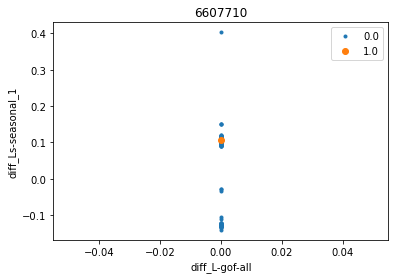

In [12]:
# plot_cols = [col for col in df_similarity.columns if (col not in coord_cols) & (col not in non_feature_cols) & (not 'target' in col)]
# plot_par_grid(df_similarity[plot_cols] )

show_cols = [col for col in df_similarity.columns.values if (col not in coord_cols) & (col not in non_feature_cols) & (not 'target' in col)]

# plot_2d_params(df_similarity, show_cols, target_col[0])
plot_2d_buffer(df_similarity, show_cols, target_col[0], 'tag')

In [13]:
def benchmarks(df, id_col, target_col, obs_dir = None, sim_dir = None,
               methods = ['CC', 'NSE', 'RMSE', 'KGE'],
               fn_out = None): 
    
    df_out = pd.DataFrame() 
    
    df_out['ID'] = df.index.values 
    df_out[id_col] = df[id_col].values 
    df_out[target_col] = df[target_col].values 
    df_out = df_out.set_index('ID')
    
    buffer_idx = df_out[id_col].unique()
    
    for i in tqdm(range(len(buffer_idx))):
        buffer_id = buffer_idx[i]
#     for buffer_id in df_out[id_col].unique():
        
        _out = df_out[ df_out[id_col] == buffer_id] 
                
        for method in methods:
            
            out_col = '{}_hat-{}'.format(target_col, method)
            
            if method in ['NSE', 'RMSE', 'KGE']:
                
                assert obs_dir.exists() , '[ERROR] obs_dir not specified or not found'
                assert sim_dir.exists(), '[ERROR] sim_dir not specified or not found'
                
                fn_obs = obs_dir / '{}_Q_Day.Cmd.txt'.format(buffer_id)
                fn_sim = sim_dir / 'buffer_{}_size-4.nc'.format(buffer_id) 
                
                ## load observations
                df_obs = pd.read_csv(fn_obs, skiprows=36, delimiter=';', encoding='cp850')
                df_obs['Q_obs'] = df_obs[' Value'] 
                df_obs['date'] = pd.to_datetime(df_obs['YYYY-MM-DD'], yearfirst=True,
                                               format='%Y-%m-%d')
                df_obs = df_obs.drop(columns=[' Value', 'YYYY-MM-DD', 'hh:mm'])
                df_obs = df_obs.set_index('date')
                df_obs.loc[ df_obs['Q_obs'] == -999., 'Q_obs'] = np.nan 
                df_obs = df_obs.loc[df_obs.index >= '1991']
                
                ## load simulations 
                ds_sim = xr.open_dataset(fn_sim)
                df_sim_list = ds_sim.to_dataframe().reset_index() 
                
                df_sim = pd.DataFrame()
                df_sim['date'] = pd.to_datetime( df_sim_list['time'].unique() )
                df_sim  = df_sim.set_index('date')
                
                for i, x_cell in enumerate( df_sim_list['x'].unique() ):
                    for j, y_cell in enumerate( df_sim_list['y'].unique() ):
                        
                        _df = df_sim_list[ (df_sim_list['x'] == x_cell) & (df_sim_list['y'] == y_cell) ]
                        
                        cell_id = '{}_{}{}'.format(buffer_id, int(i+1), int(j+1)) 
                        time = pd.to_datetime(_df['time'])
                        df_sim.loc[time, cell_id] = _df['dis24'].values 
                
                ## set simulations to observations extent 
                max_date = df_obs.tail(1).index.values[0]
                min_date = df_obs.head(1).index.values[0]
                df_sim = df_sim.loc[ (df_sim.index>=min_date) & (df_sim.index <= max_date)].copy()    
                
                ## mask and drop NaN values based on observations 
                gauge_mask = df_obs[df_obs['Q_obs'].isnull()>0].index 
                df_obs = df_obs.drop(index=gauge_mask)
                df_sim = df_sim.drop(index=gauge_mask)   
                
                ## calculate selected metrics in the buffer 
                for cell in df_sim.columns:
                    
                    if method == 'NSE':
                        try:
                            res = he.evaluator(he.nse, df_sim[cell].values, df_obs['Q_obs'].values )[0]
                        except:
                            print(buffer_id)
                            print(df_obs.head(2))
                            print(df_obs.tail(2))
                            print(df_sim.head(2).index)
                            print(df_sim.tail(2).index)
                            
                        
                    if method == 'RMSE':
                        res = he.evaluator(he.rmse, df_sim[cell].values, df_obs['Q_obs'].values )[0]  
                        
                    if method == 'KGE':
                        res, r, alpha, beta = he.evaluator(he.kge, df_sim[cell].values, df_obs['Q_obs'].values ) 

                    df_out.loc[cell, method] = res 
                
                if method == 'NSE':
                    y_hat_ix = df_out.loc[_out.index, method].idxmax()
                if method == 'RMSE':
                    y_hat_ix = df_out.loc[_out.index, method].idxmin()
                if method == 'KGE':
                    y_hat_ix = df_out.loc[_out.index, method].idxmax()
                        
                
                df_out.loc[_out.index, out_col] = 0 
                df_out.loc[y_hat_ix, out_col] = 1

            if method == 'CC': 
                df_out.loc[ _out.index, out_col ] = 0 
                center_ix = df[ (df['n_buffer'] == 0) & (df[id_col]==buffer_id)].index
                df_out.loc[center_ix, out_col] = 1 
            
    df_out = df_out.dropna(axis=0)
                
    if fn_out == None:
        return df_out
    else:
        df_out.to_csv(fn_out)
        return fn_out 

In [14]:
### splitting and scaling 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, balanced_accuracy_score 
from sklearn.linear_model import LogisticRegression 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 

# Steps:
# 1 - split a train/validation and test set (70:15:15 --> 85:15) (or 60:20:20 --> 80:20)

# 2 - on train/validation set, perform a k-fold validation 
#     a. split training/validation (70:15) ()
#     b. subsample training set 
#     c. scale training set, use scaler to scale validation set 
#     d. train model
#     e. validate and save performance 
#     f. save and repeat k-fold times 
#     g. use average? major? vote to assess testing performance  

## first split data based on being inside or outside the buffer zone (=4)
df_outside_buffer = df_similarity[ df_similarity['target'] == -1].copy() 
gauge_outside = df_outside_buffer['tag'].unique().astype(int)

fn_gauge = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\training_data_S1")  / "V1_grdc_efas_selection-cartesius-snapped-1.csv" 
meta_gauge = pd.read_csv(fn_gauge, index_col = 0)

## analyse replacements 
df_meta_gauge = meta_gauge.loc[gauge_outside]
print('{} gauges / buffers fall outside the buffer zone of 4:'.format(len(gauge_outside)))
print(df_meta_gauge[['d_X_cell', 'd_Y_cell']].describe())
# print(df_meta_gauge[['d_X_cell', 'd_Y_cell']])

## copy data inside buffer to new dataframe 
df_inside_buffer = df_similarity.drop(index=df_outside_buffer.index) 

print('Analyse size of buffer or searching range with number of hits:')
for buffer_size in np.sort(df_inside_buffer['n_buffer'].unique()):
    n_hits = df_inside_buffer[ (df_inside_buffer['n_buffer'] == buffer_size) ]['target'].sum()
    print('In a search range of {:.0f} cells, {:.0f} matches are found'.format(buffer_size, n_hits))


## get buffers based on location of match 
buffer_0 = df_inside_buffer[ (df_inside_buffer['n_buffer'] == 0) & (df_inside_buffer['target']==1) ]['tag'].unique()
buffer_1 = df_inside_buffer[ (df_inside_buffer['n_buffer'] == 1) & (df_inside_buffer['target']==1) ]['tag'].unique()
buffer_2 = df_inside_buffer[ (df_inside_buffer['n_buffer'] == 2) & (df_inside_buffer['target']==1) ]['tag'].unique()
buffer_3 = df_inside_buffer[ (df_inside_buffer['n_buffer'] == 3) & (df_inside_buffer['target']==1) ]['tag'].unique()
buffer_4 = df_inside_buffer[ (df_inside_buffer['n_buffer'] == 4) & (df_inside_buffer['target']==1) ]['tag'].unique()

## split with same ratio 
train_val_0, test_0 = train_test_split(buffer_0, test_size=0.15, random_state=21)
train_val_1, test_1 = train_test_split(buffer_1, test_size=0.15, random_state=21)
train_val_2, test_2 = train_test_split(buffer_2, test_size=0.15, random_state=21)
train_val_3, test_3 = train_test_split(buffer_3, test_size=0.15, random_state=21)
train_val_4, test_4 = train_test_split(buffer_4, test_size=0.15, random_state=21)

## combine all sets 
id_train_val = np.concatenate( (train_val_0, train_val_1, train_val_2, train_val_3, train_val_4) )
id_test = np.concatenate((test_0, test_1, test_2, test_3, test_4))

## split data 
df_train_val = df_inside_buffer[ df_inside_buffer['tag'].isin(id_train_val) ].copy()
df_test = df_inside_buffer[ df_inside_buffer['tag'].isin(id_test) ].copy()

print('\nShow result of split:')
print('Train val set:')
print( df_train_val.groupby(by='n_buffer')['target'].sum() )
print('\nTest set')
print( df_test.groupby(by='n_buffer')['target'].sum() )

## list feature columns 
feature_columns = df_similarity.columns.values 
## remove non_feature cols 

if omit_coords:
    for col in non_feature_cols+target_col+coord_cols:
        col_ix = np.where(feature_columns==col)[0]
        feature_columns = np.delete(feature_columns, col_ix)

else:
    for col in non_feature_cols+target_col:
        col_ix = np.where(feature_columns==col)[0]
        feature_columns = np.delete(feature_columns, col_ix)    
        
        
#  Try differenct scalers: MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer 
# sc = MinMaxScaler() 
# ss = StandardScaler()
# rsc = RobustScaler()
# pt = PowerTransformer()


# pt = PowerTransformer()
# sc = MinMaxScaler() 

# X_train_val = pt.fit_transform(df_train_val[feature_columns])
# X_train_val = sc.fit_transform(X_train_val)

# X_test = pt.transform(df_test[feature_columns])
# X_test = sc.transform(X_test)   


23 gauges / buffers fall outside the buffer zone of 4:
         d_X_cell    d_Y_cell
count   23.000000   23.000000
mean   -20.826087   -6.086957
std     55.257786   54.266106
min   -214.000000 -250.000000
25%    -11.500000   -1.000000
50%     -4.000000    6.000000
75%      2.000000   10.500000
max     13.000000   30.000000
Analyse size of buffer or searching range with number of hits:
In a search range of 0 cells, 244 matches are found
In a search range of 1 cells, 284 matches are found
In a search range of 2 cells, 32 matches are found
In a search range of 3 cells, 9 matches are found
In a search range of 4 cells, 3 matches are found

Show result of split:
Train val set:
n_buffer
0.0    207.0
1.0    241.0
2.0     27.0
3.0      7.0
4.0      2.0
Name: target, dtype: float64

Test set
n_buffer
0.0    37.0
1.0    43.0
2.0     5.0
3.0     2.0
4.0     1.0
Name: target, dtype: float64


In [22]:
# ## do a PCA analysis on the data 
# ## n_components vs variability explained 

df_pca = df_inside_buffer[feature_columns].copy() 
print('Original shape of data: {} samples and {} features'.format( df_pca.shape[0], df_pca.shape[1] ))

## first scale data 
pt = PowerTransformer()
X_scale = pt.fit_transform(df_pca.values)
sc = MinMaxScaler([0,1])
X_scale = sc.fit_transform(X_scale)

## default 
pca = PCA()
pca.fit(X_scale)
var_explained = pca.explained_variance_ratio_ 
cumulative_var = np.cumsum(var_explained)

## set amount variance explained 
min_var_explained = 0.9
min_components = len(np.where(cumulative_var <= min_var_explained)[0])

## can also try:
pca_r = PCA(n_components=min_var_explained)
pca_r.fit(X_scale)
X_pca_r = pca_r.transform(X_scale)
print('A dataset that explains {:.0f}% of variance is described with {} principal components'.format( min_var_explained*100,
                                                                                               X_pca_r.shape[1]))

Original shape of data: 44792 samples and 76 features
A dataset that explains 90% of variance is described with 14 principal components


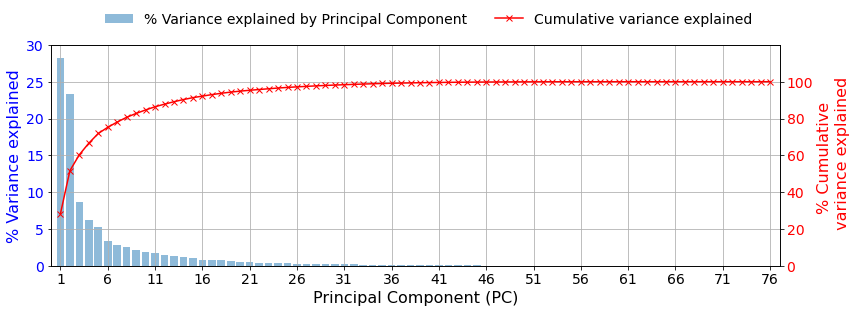

In [65]:
## display 
fig, ax1 = plt.subplots(1, figsize=(12,4)) 

ax1.bar(list(range(len(var_explained))), var_explained, alpha=0.5, 
        label = '% Variance explained by Principal Component' )

ax1.grid()
ax1.set_xticks(np.arange(0, len(var_explained),5))
ax1.set_xticklabels( [ int(v+1) for v in np.arange(0, len(var_explained),5) ], size=14 )
ax1.set_yticks(np.arange(0,0.31,0.05));
ax1.set_yticklabels([ int(v) for v in np.arange(0,0.31,0.05)*100], color='b', size=14);
ax1.set_xlabel('Principal Component (PC)', size=16)
ax1.set_ylabel('% Variance explained', color='b', size=16)
ax1.set_xlim(-1, len(var_explained))


ax2 = ax1.twinx() 
# ax2.axhline(min_var_explained, color='k', linestyle='--', linewidth = 0.8, 
#             label = '{:.0f} variance explained'.format(min_var_explained*100))

ax2.plot(list(range(len(cumulative_var))), cumulative_var, marker='x', color = 'r', 
         label='Cumulative variance explained')
ax2.set_yticks( np.arange(0,1.01,0.2) );
ax2.set_yticklabels([ int(v) for v in np.arange(0,1.01,0.2)*100], color='r', size=14 );
ax2.set_ylabel('% Cumulative \n variance explained', color='r', size=16);
ax2.set_ylim(0,1.2);

lgd = fig.legend(fontsize=14, ncol=2, loc='upper center', frameon=False,
                bbox_to_anchor = (0.5, 1.1));
plt.tight_layout()
# fig.savefig('pca-variance.png', bbox_inches='tight') #, bbox_extra_artist=[lgd])

In [16]:
# ## which components important? 
# X_pca = pca.transform(X_scale)
# pca_cols = ['PC{}'.format(int(i+1)) for i in range(X_pca.shape[1]) ]
# df_transformed = pd.DataFrame(data=X_pca, 
#                               columns= pca_cols)

# ## relate PC's to original data 
# df_scaled = pd.DataFrame(data=X_scale,
#                         columns = feature_columns)

# df_correlate = pd.DataFrame()

# for i, fcol in enumerate(feature_columns):
#     for j, pcol in enumerate(pca_cols): 
#         df_correlate.loc[fcol, pcol] = df_scaled[fcol].corr(df_transformed[pcol])

In [17]:
# plt.figure(figsize=(14,8))
# sns.heatmap(df_correlate, cmap="vlag", vmin = -1., vmax=1)
# plt.savefig('pca_feature_corr.png')

In [18]:
# ## summarize components 
# df_components = pd.DataFrame(data=pca.components_,
#                             index = pca_cols,
#                             columns = feature_columns)

# plt.figure(figsize=(14,8))
# sns.heatmap(df_components.transpose(), cmap="vlag", vmin=-1, vmax=1)
# # plt.savefig('pca_principal_axes.png')

In [19]:
## now conduct PCA on training/validation and test set 

pca = PCA(n_components=0.9)
pca.fit(X_train_val)
X_train_val = pca.transform(X_train_val)
X_test = pca.transform(X_test)

## create new dataframes with PCA data 
pca_cols = [f'PC{v+1}' for v in range(X_train_val.shape[1])]
df_train_val_pca = pd.DataFrame(data=X_train_val,
                                columns = pca_cols,
                                index = df_train_val.index
                               )

df_train_val_pca[['target', 'tag']] = df_train_val[['target', 'tag']] 
df_train_val_pca[coord_cols] = df_train_val[coord_cols]


df_test_pca = pd.DataFrame(data = X_test,
                          columns = pca_cols,
                          index = df_test.index)
df_test_pca[['target', 'tag']] = df_test[['target', 'tag']] 
df_test_pca[coord_cols] = df_test[coord_cols]

NameError: name 'X_train_val' is not defined

In [ ]:
df_components = pd.DataFrame(data=pca.components_,
                            index = pca_cols[:X_train_val.shape[1]],
                            columns = feature_columns)

plt.figure(figsize=(14,2))
sns.heatmap(df_components, cmap="vlag", vmin=-1, vmax=1)

In [ ]:
fig = plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title('% variance explained')
plt.bar(list(range(len(var_explained))), var_explained )
plt.xlim(-1, len(var_explained)+1)
plt.yticks(np.arange(0,0.31,0.05), [ int(v) for v in np.arange(0,0.31,0.05)*100] )
plt.xlabel('principal components')
plt.xlabel('% variance')
plt.grid()

plt.subplot(122)
plt.title('Cumulative % variance explained')
cumulative_var = np.cumsum(var_explained)
plt.plot(list(range(len(cumulative_var))), cumulative_var, marker='x')
plt.xlim(-1, len(var_explained))
plt.ylim(0, 1.05)
plt.yticks(np.arange(0,1.1,0.2), [ int(v) for v in np.arange(0,1.01,0.2)*100] )
plt.xlabel('principal components')
plt.xlabel('% variance')
plt.grid()

In [116]:
## load or calculate benchmarks 
calc_bench = False
fn_bench = signature_dir / "S1_benchmarks.csv" 

if calc_bench:

    base_dir = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\training_data_S1") 

    obs_dir = base_dir / "V1" 
    sim_dir = base_dir / "efas_output_nc"

    df_benchmarks = benchmarks(df_similarity, 'tag', target_col[0], 
                               obs_dir, sim_dir) #, fn_out = fn_bench)

else:
    df_benchmarks = pd.read_csv(fn_bench, index_col=0)

df_benchmarks

df_benchmarks['range_target'] = df_similarity['range_target']

benchmarks_train_val = df_benchmarks[df_benchmarks['tag'].isin(id_train_val)]
benchmarks_test = df_benchmarks[df_benchmarks['tag'].isin(id_test)]

In [117]:
## apply K-fold cross validation on different algorithms 

def compute_metrics(y, y_hat, k, model_name, normalize = None):
     
    cm = confusion_matrix(y, y_hat, normalize=normalize) 
    accuracy = accuracy_score(y, y_hat)    
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    f1 = f1_score(y, y_hat)
    balanced_accuracy = balanced_accuracy_score(y, y_hat)
    tn, fn, tp, fp = cm[0,0], cm[1,0], cm[1,1], cm[0,1] 
    
    return_df = pd.DataFrame({
                            'k': [k],
                            'model': [model_name],
                            'accuracy': [accuracy],
                            'balanced_acc': [balanced_accuracy],
                            'precision': [precision],
                            'recall': [recall],
                            'f1': [f1],
                            'n': [len(y)],
                            'N': [y.sum()],
                            'TP': [tp],
                            'TN': [tn],
                            'FP': [fp],
                            'FN': [fn]
                              })     
    return return_df 


def classify_buffer(model_method, scaler_1, scaler_2,
                    df, id_col, feature_cols, target_col, prediction_col,
                    fit_pca = None):
    
    for idx in df[id_col].unique():
        
        ## get buffer 
        buffer = df[ df[id_col] == idx]
        
        ## split X and y
        X, y = buffer[feature_cols].copy(), buffer[target_col].copy() 
        
        if scaler_1 != None:
            ## scale X
            X = scaler_1.transform(X) 
        
        if scaler_2 != None:
            X = scaler_2.transform(X)

        if fit_pca != None:
            X = fit_pca.transform(X)
        
        ## use provided model to predict y_hat
        y_hat = model_method(X) 
        
        if len(y_hat.shape) == 2:
            y_hat_0 = y_hat[:,0]
            y_hat_1 = y_hat[:,1] 
                        
            df.loc[buffer.index, '{}_p0'.format(prediction_col)] = y_hat_0
            df.loc[buffer.index, '{}_p1'.format(prediction_col)] = y_hat_1 
            
            y_hat = np.zeros(len(y_hat_0))             
            y_hat[ np.argmax(y_hat_1) ] = 1 
                        
        ## add y_hat to input df 
        df.loc[buffer.index, prediction_col] = y_hat 
            
    return df 


def k_foldCV_val(df, id_col, target_col, feature_cols, 
                 K = 5, n_subsample = 1, do_transform = True, do_scale = True,
                 do_PCA = False, n_PCA = 4, pca_whiten = False,
                 methods=['LogisticRegressor-1', 'LogisticRegressor-2', 'k-nn', 
                          'RF-0', 'RF-1', 'RF-2', 'SVM-1', 'SVM-2'],
                 benchmarks = ['CC', 'NSE', 'RMSE', 'KGE'],
                 df_benchmarks = None,
                 normalize_cm = None):
    
    ## create dataframe for performance summary
    df_performance = pd.DataFrame(columns=['k', 'model', 
                                           'accuracy', 'precision', 'recall', 
                                           'f1', 'n', 'TP', 'TN', 'FP', 'FN']) 
            
    ## identify buffer id 
    buffer_idx = df[id_col].unique()
    ## shuffle 
#     np.random.seed(26)
    np.random.shuffle(buffer_idx)
    ## split in K folds 
    k_split_idx = np.array_split(buffer_idx, K)
    
    test_col = 'range_{}'.format(target_col)
    
    for k in tqdm(range(K)):
                
        ## split validation and training set based on size of K 
        id_val = k_split_idx[k]
        id_train = np.setdiff1d(buffer_idx, id_val)

        df_val = df[ df[id_col].isin(id_val)].copy()
        df_train = df[ df[id_col].isin(id_train)].copy()
        
        ## subsample df_train 
        df_train_1 = df_train[ df_train[target_col] == 1]

        # sample from each buffer 
        df_train_0_ix = []
        for i, idx in enumerate(id_train):
            _df = df_train[ (df_train[target_col] != 1) & (df_train[id_col] == idx) ] 
            subsamples = _df.sample(n=n_subsample).index 
#             subsamples = _df.sample(n=n_subsample, random_state=21).index 
            for sample in subsamples:
                df_train_0_ix.append(sample)

        df_train_0 = df_train.loc[df_train_0_ix]
        df_train = df_train_1.append(df_train_0)
        
        ## split X and y 
        X_train, y_train = df_train[feature_cols].copy(), df_train[target_col].copy()
                
        ## transform X_train with PowerTransformer 
        if do_transform:
            pt = RobustScaler()
            X_train = pt.fit_transform(X_train)
        else:
            pt = None 
            
        ## scale X_train by training MinMax scaler
        if do_scale:
            sc = MinMaxScaler([0,1])
            X_train = sc.fit_transform(X_train) 
        else:
            sc = None 
        
        ## fit PCA transformation  
        if do_PCA:
            pca = PCA(n_components = n_PCA, whiten = pca_whiten)
            X_train = pca.fit_transform(X_train)
        else:
            pca = None
            
        if 'LogisticRegressor-1' in methods:
            
            lr_1 = LogisticRegression(max_iter=200)
            lr_1.fit(X_train, y_train)
                        
            hat_col = '{}_hat-LR1'.format(target_col)
            
            df_val = classify_buffer( lr_1.predict, pt, sc,
                                      df_val, id_col, 
                                      feature_cols, target_col,
                                      hat_col, fit_pca = pca)
            
            
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[test_col], df_val[hat_col],
                                                    int(k+1), 'LogisticRegressor-1', normalize=normalize_cm ) )

#             df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
#                                                     int(k+1), 'LogisticRegressor-1', normalize=normalize_cm ) )            
            
        if 'LogisticRegressor-2' in methods:
            
            lr_2 = LogisticRegression(max_iter=200)
            lr_2.fit(X_train, y_train)
            
            hat_col = '{}_hat-LR2'.format(target_col) 
            
            df_val = classify_buffer( lr_2.predict_proba, pt, sc,
                                      df_val, id_col, 
                                      feature_cols, target_col,
                                      hat_col, fit_pca = pca) 
                     
            ## compute metrics
#             df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
#                                                     int(k+1), 'LogisticRegressor-2', normalize=normalize_cm) )
            df_performance = df_performance.append( compute_metrics(df_val[test_col], df_val[hat_col],
                                                    int(k+1), 'LogisticRegressor-2', normalize=normalize_cm) )
            
        if 'k-nn' in methods:
            
            if not do_PCA:
                pca = PCA(n_components = 3)
                X_train = pca.fit_transform(X_train)
            
            kmeans = KMeans(n_clusters=2)
            kmeans.fit(X_train, y_train)
            
            hat_col = '{}_hat-KM'.format(target_col)
            
            df_val = classify_buffer( kmeans.predict, pt, sc,
                                      df_val, id_col, 
                                      feature_cols, target_col,
                                      hat_col, fit_pca = pca) 
                     
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[test_col], df_val[hat_col],
                                                    int(k+1), 'k-nn', normalize=normalize_cm) )
#             df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
#                                                     int(k+1), 'k-nn', normalize=normalize_cm) )
            
        if 'RF-1' in methods:
            
            clf = RandomForestClassifier(random_state = 21)
            clf.fit(X_train, y_train)
            
            hat_col = '{}_hat-RF1'.format(target_col)

            df_val = classify_buffer( clf.predict, pt, sc,
                                      df_val, id_col, 
                                      feature_cols, target_col,
                                      hat_col, fit_pca = pca) 
                     
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
                                                    int(k+1), 'RF-1', normalize=normalize_cm) )
            
        if 'RF-2' in methods:
            
            clf = RandomForestClassifier(random_state = 21,
                                        class_weight = "balanced_subsample")
            clf.fit(X_train, y_train)
            
            hat_col = '{}_hat-RF2'.format(target_col)

            df_val = classify_buffer( clf.predict_proba, pt, sc,
                                      df_val, id_col, 
                                      feature_cols, target_col,
                                      hat_col, fit_pca = pca) 
                     
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[test_col], df_val[hat_col],
                                                    int(k+1), 'RF-2', normalize=normalize_cm) )
#             df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
#                                                     int(k+1), 'RF-2', normalize=normalize_cm) 
            
        if 'SVM-1' in methods:
            
            svc = SVC(probability = True)
            
            svc.fit(X_train, y_train)
            
            hat_col = '{}_hat-SVM1'.format(target_col)
            
            df_val = classify_buffer( svc.predict, pt, sc,
                                      df_val, id_col,
                                      feature_cols, target_col,
                                      hat_col, fit_pca = pca)
            
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[test_col], df_val[hat_col],
                                                    int(k+1), 'SVM-1', normalize=normalize_cm) )            
#             df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
#                                                     int(k+1), 'SVM-1', normalize=normalize_cm) )  
            
        if 'SVM-2' in methods:
            
            svc = SVC(probability = True)
            
            svc.fit(X_train, y_train)
            
            hat_col = '{}_hat-SVM2'.format(target_col)
            
            df_val = classify_buffer( svc.predict_proba,pt, sc,
                                      df_val, id_col,
                                      feature_cols, target_col,
                                      hat_col, fit_pca = pca)
            
            ## compute metrics
            df_performance = df_performance.append( compute_metrics(df_val[test_col], df_val[hat_col],
                                                    int(k+1), 'SVM-2', normalize=normalize_cm) )            
#             df_performance = df_performance.append( compute_metrics(df_val[target_col], df_val[hat_col],
#                                                     int(k+1), 'SVM-2', normalize=normalize_cm) ) 
            
        if len(benchmarks) > 0:
                      
            assert df_benchmarks is not None, '[ERROR] benchmark data not specified'
            
            ## get validation benchmark data 
            benchmark_val = df_benchmarks[ df_benchmarks[id_col].isin(id_val)].copy() 
                        
            ## loop over given benchmarks 
            for bench in benchmarks:
                
                ## find column 
                bench_hat_col = [ col for col in df_benchmarks.columns if (bench in col) & ('hat' in col)][0]
                bench_col = [ col for col in df_benchmarks.columns if (bench in col) & (not 'hat' in col)]
                
                ## add scores - if they exist
                if len(bench_col) > 0:
                    df_val.loc[benchmark_val.index, bench_col[0]] = benchmark_val[bench_col]
                
                ## calculate metrics 
                df_performance = df_performance.append( compute_metrics( benchmark_val[test_col], 
                                                                        benchmark_val[bench_hat_col],
                                                        int(k+1), bench_hat_col.split('-')[-1], normalize=normalize_cm) ) 
#                 df_performance = df_performance.append( compute_metrics( benchmark_val[target_col], 
#                                                                         benchmark_val[bench_hat_col],
#                                                         int(k+1), bench_hat_col.split('-')[-1], normalize=normalize_cm) ) 
                
                
    ## need to set datatype explicitly
    df_performance = df_performance.astype({'TP': 'float64',
                                            'TN': 'float64',
                                            'FP': 'float64',
                                            'FN': 'float64',
                                            'k' : 'int32',
                                            'n' : 'int32',
                                            'N' : 'int32'})
    
    ## return classification results and performance summary 
    return df_val, df_performance

def plot_heatmap(data):
    
    plt.figure()
    
    sns.heatmap(data.values, cmap = sns.diverging_palette(220, 20, as_cmap=True) )# cmap="vlag") 
    
    rows, cols = data.values.shape 
    y_ticks = np.arange(0,rows)
    x_ticks = np.arange(0,cols)

    plt.xticks(x_ticks+0.5, data.columns, rotation = 30)
    plt.yticks(y_ticks+0.5, data.index, rotation = 0)
    plt.show()
    return 

## try to find best PCA value
def vary_pca(min_pca=1, max_pca=5, methods = ['LogisticRegressor-1', 'LogisticRegressor-2']):
    
    ## set pca component interations 
    iter_pca =list(range(min_pca, int(max_pca+1))) 
    
    ## empty array for ouptut 
    mean_results = np.zeros((len(iter_pca), 4, len(methods)))
    min_results  = np.zeros(mean_results.shape)
    max_results  = np.zeros(mean_results.shape)
    
    confusion_cols = ['TP', 'TN', 'FP', 'FN']
        
    ## start iterations 
    for i, i_pca in enumerate(iter_pca):
        
        df_CV, df_performance =  k_foldCV_val( df_train_val, 'tag', target_col[0], feature_columns, 
                                               methods = methods, benchmarks = [],
                                                 do_PCA = True, n_PCA = i_pca) 
        
        summarize_performance = df_performance.groupby(by='model')[confusion_cols]
        
        mean_vals = summarize_performance.mean()
        min_vals  = summarize_performance.min()
        max_vals  = summarize_performance.max()
                
        ## save output per method 
        for j in range(len(methods)):
            method = methods[j] 
            
            mean_results[ i, :, j] = mean_vals.loc[methods[j], confusion_cols].values 
            min_results[ i, :, j]  = min_vals.loc[methods[j], confusion_cols].values 
            max_results[ i, :, j]  = max_vals.loc[methods[j], confusion_cols].values 
            
    plt.figure() 

    fig, axs = plt.subplots(4, figsize=(12,10)) 

    for i in range(len(confusion_cols)):

        axs[i].set_title(confusion_cols[i])

        for j in range(len(methods)):        
            
            axs[i].fill_between(iter_pca, min_results[:,i,j], max_results[:,i,j], alpha=0.25 )
            axs[i].plot(iter_pca, mean_results[:,i,j])
            
        axs[i].grid()
        
        if len(methods) > 1:
            axs[i].set_yscale('log')

    fig.tight_layout()
    plt.show()
    
    return

In [118]:
## loop over k_fold 10 times (or more) for more stable results 
n_folds = 10
stat_cols = ['accuracy', 'balanced_acc', 'precision', 'recall', 'f1',  
             'TP', 'TN', 'FP', 'FN', 'hit_ratio', 'n', 'N']

std_cols = ['accuracy', 'balanced_acc', 'precision', 'recall', 'f1',  
             'TP', 'TN', 'FP', 'FN', 'hit_ratio']

In [119]:
## performance of all models/benchmarks - all features, transformed & scaled 
n_fold_base_performance = pd.DataFrame() 
for i in range(n_folds):
    
    df_CV_0, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                                           methods = ['LogisticRegressor-1', 'LogisticRegressor-2', 'k-nn', 
                                           'RF-1', 'RF-2', 'SVM-1', 'SVM-2'], 
                                            df_benchmarks=benchmarks_train_val)
    
    n_fold_base_performance = n_fold_base_performance.append(df_performance)

n_fold_base_performance['type'] = 'algorithm'
n_fold_base_performance.loc[ n_fold_base_performance['model'].isin(['CC', 'KGE', 'NSE', 'RMSE']), 'type' ] = 'benchmark'
n_fold_base_performance['hit_ratio'] = n_fold_base_performance['TP'] / n_fold_base_performance['N']

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:40<00:26, 13.20s/it]C:\Users\mvand\anaconda3\envs\sandbox\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\mvand\anaconda3\envs\sandbox\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.35s/it]


In [120]:
n_fold_PCA_80_performance = pd.DataFrame()

for i in range(n_folds):
    df_CV_1, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                                           methods = ['LogisticRegressor-1', 'LogisticRegressor-2', 'k-nn', 
                                                      'RF-1', 'RF-2', 'SVM-1', 'SVM-2'], 
                                           df_benchmarks=benchmarks_train_val, # benchmarks = ['CC'],
                                           do_PCA = True, n_PCA = 0.8 )
    
    n_fold_PCA_80_performance = n_fold_PCA_80_performance.append(df_performance)

n_fold_PCA_80_performance['type'] = 'algorithm'
n_fold_PCA_80_performance.loc[ n_fold_PCA_80_performance['model'].isin(['CC', 'KGE', 'NSE', 'RMSE']), 'type' ] = 'benchmark'
n_fold_PCA_80_performance['hit_ratio'] = n_fold_PCA_80_performance['TP'] / n_fold_PCA_80_performance['N']

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\mvand\anaconda3\envs\sandbox\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\mvand\anaconda3\envs\sandbox\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.80s/it]


In [121]:
n_fold_PCA_90_performance = pd.DataFrame()

for i in range(n_folds):
    df_CV_1, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                                           methods = ['LogisticRegressor-1', 'LogisticRegressor-2', 'k-nn', 
                                                      'RF-1', 'RF-2', 'SVM-1', 'SVM-2'], 
                                           df_benchmarks=benchmarks_train_val, # benchmarks = ['CC'],
                                           do_PCA = True, n_PCA = 0.9 )
    
    n_fold_PCA_90_performance = n_fold_PCA_90_performance.append(df_performance)

n_fold_PCA_90_performance['type'] = 'algorithm'
n_fold_PCA_90_performance.loc[ n_fold_PCA_90_performance['model'].isin(['CC', 'KGE', 'NSE', 'RMSE']), 'type' ] = 'benchmark'
n_fold_PCA_90_performance['hit_ratio'] = n_fold_PCA_90_performance['TP'] / n_fold_PCA_90_performance['N']

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:10<00:00, 14.15s/it]


In [122]:
n_fold_PCA_95_performance = pd.DataFrame()

for i in range(n_folds):
    df_CV_1, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                                           methods = ['LogisticRegressor-1', 'LogisticRegressor-2', 'k-nn', 
                                                      'RF-1', 'RF-2', 'SVM-1', 'SVM-2'], 
                                           df_benchmarks=benchmarks_train_val, # benchmarks = ['CC'],
                                           do_PCA = True, n_PCA = 0.95 )
    
    n_fold_PCA_95_performance = n_fold_PCA_95_performance.append(df_performance)

n_fold_PCA_95_performance['type'] = 'algorithm'
n_fold_PCA_95_performance.loc[ n_fold_PCA_95_performance['model'].isin(['CC', 'KGE', 'NSE', 'RMSE']), 'type' ] = 'benchmark'
n_fold_PCA_95_performance['hit_ratio'] = n_fold_PCA_95_performance['TP'] / n_fold_PCA_95_performance['N']

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.96s/it]


In [123]:
n_fold_PCA_97_performance = pd.DataFrame()

for i in range(n_folds):
    df_CV_1, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                                           methods = ['LogisticRegressor-1', 'LogisticRegressor-2', 'k-nn', 
                                                      'RF-1', 'RF-2', 'SVM-1', 'SVM-2'], 
                                           df_benchmarks=benchmarks_train_val, # benchmarks = ['CC'],
                                           do_PCA = True, n_PCA = 0.97 )
    
    n_fold_PCA_97_performance = n_fold_PCA_97_performance.append(df_performance)

n_fold_PCA_97_performance['type'] = 'algorithm'
n_fold_PCA_97_performance.loc[ n_fold_PCA_97_performance['model'].isin(['CC', 'KGE', 'NSE', 'RMSE']), 'type' ] = 'benchmark'
n_fold_PCA_97_performance['hit_ratio'] = n_fold_PCA_97_performance['TP'] / n_fold_PCA_97_performance['N']

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\mvand\anaconda3\envs\sandbox\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:54<00:13, 13.59s/it]C:\Users\mvand\anaconda3\envs\sandbox\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:07<00:00, 13.52s/it]


In [124]:
n_fold_PCA_99_performance = pd.DataFrame()

for i in range(n_folds):
    df_CV_1, df_performance = k_foldCV_val(df_train_val, 'tag', target_col[0], feature_columns, 
                                           methods = ['LogisticRegressor-1', 'LogisticRegressor-2', 'k-nn', 
                                                      'RF-1', 'RF-2', 'SVM-1', 'SVM-2'], 
                                           df_benchmarks=benchmarks_train_val, # benchmarks = ['CC'],
                                           do_PCA = True, n_PCA = 0.99 )
    
    n_fold_PCA_99_performance = n_fold_PCA_99_performance.append(df_performance)

n_fold_PCA_99_performance['type'] = 'algorithm'
n_fold_PCA_99_performance.loc[ n_fold_PCA_99_performance['model'].isin(['CC', 'KGE', 'NSE', 'RMSE']), 'type' ] = 'benchmark'
n_fold_PCA_99_performance['hit_ratio'] = n_fold_PCA_99_performance['TP'] / n_fold_PCA_99_performance['N']

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:10<00:00, 14.13s/it]


In [125]:
print('\n\nBenchmark performance:')
n_fold_base_performance.groupby(by=[ 'type', 'model'])[stat_cols].mean()



Benchmark performance:


accuracy  balanced_acc  precision    recall  \
type      model                                                              
algorithm LogisticRegressor-1  0.703654      0.752033   0.096918  0.804445   
          LogisticRegressor-2  0.950752      0.506839   0.077891  0.025964   
          RF-1                 0.631566      0.634920   0.022210  0.638361   
          RF-2                 0.951671      0.513069   0.113836  0.037945   
          SVM-1                0.638171      0.651110   0.069250  0.665122   
          SVM-2                0.951132      0.509420   0.092781  0.030927   
          k-nn                 0.562613      0.500447   0.036276  0.433078   
benchmark CC                   0.967018      0.616884   0.712786  0.237595   
          KGE                  0.956853      0.548128   0.316106  0.105369   
          NSE                  0.956958      0.548843   0.320230  0.106743   
          RMSE                 0.956958      0.548843   0.320230  0.106743   

                                     f1      TP       TN       FP      FN  \
type      model                                                             
algorithm LogisticRegressor-1  0.172917  233.60  5083.60  2182.40   56.80   
          LogisticRegressor-2  0.038945    7.54  7176.74    89.26  282.86   
          RF-1                 0.042911   61.80  4710.66  2748.94   35.00   
          RF-2                 0.056918   11.02  7180.22    85.78  279.38   
          SVM-1                0.125204  193.16  4628.70  2637.30   97.24   
          SVM-2                0.046391    8.98  7178.18    87.82  281.42   
          k-nn                 0.065963  125.78  4123.10  3142.90  164.62   
benchmark CC                   0.356393   69.00  7238.20    27.80  221.40   
          KGE                  0.158053   30.60  7199.80    66.20  259.80   
          NSE                  0.160115   31.00  7200.20    65.80  259.40   
          RMSE                 0.160115   31.00  7200.20    65.80  259.40   

                               hit_ratio       n      N  
type      model                                          
algorithm LogisticRegressor-1   0.804445  7556.4  290.4  
          LogisticRegressor-2   0.025964  7556.4  290.4  
          RF-1                  0.638361  7556.4   96.8  
          RF-2                  0.037945  7556.4  290.4  
          SVM-1                 0.665122  7556.4  290.4  
          SVM-2                 0.030927  7556.4  290.4  
          k-nn                  0.433078  7556.4  290.4  
benchmark CC                    0.237595  7556.4  290.4  
          KGE                   0.105369  7556.4  290.4  
          NSE                   0.106743  7556.4  290.4  
          RMSE                  0.106743  7556.4  290.4

In [126]:
# n_fold_base_performance.groupby(by=[ 'type', 'model'])[std_cols].std()

In [127]:
print('With PCA (80% variance explained):')
n_fold_PCA_80_performance.groupby(by=[ 'type', 'model'])[stat_cols].mean()

With PCA (80% variance explained):


accuracy  balanced_acc  precision    recall  \
type      model                                                              
algorithm LogisticRegressor-1  0.688873      0.728513   0.089531  0.771461   
          LogisticRegressor-2  0.950577      0.505658   0.071076  0.023692   
          RF-1                 0.708629      0.743933   0.033617  0.780168   
          RF-2                 0.953100      0.522732   0.169583  0.056528   
          SVM-1                0.672419      0.761426   0.093138  0.857847   
          SVM-2                0.950570      0.505623   0.070876  0.023625   
          k-nn                 0.531420      0.500341   0.036181  0.466657   
benchmark CC                   0.967020      0.616878   0.712743  0.237581   
          KGE                  0.956854      0.548133   0.316136  0.105379   
          NSE                  0.956963      0.548849   0.320260  0.106753   
          RMSE                 0.956963      0.548849   0.320260  0.106753   

                                     f1      TP       TN       FP      FN  \
type      model                                                             
algorithm LogisticRegressor-1  0.160384  224.04  4981.94  2284.06   66.36   
          LogisticRegressor-2  0.035538    6.88  7176.08    89.92  283.52   
          RF-1                 0.064441   75.52  5279.50  2180.10   21.28   
          RF-2                 0.084792   16.42  7185.62    80.38  273.98   
          SVM-1                0.167974  249.12  4831.80  2434.20   41.28   
          SVM-2                0.035438    6.86  7176.06    89.94  283.54   
          k-nn                 0.066192  135.52  3878.48  3387.52  154.88   
benchmark CC                   0.356371   69.00  7238.20    27.80  221.40   
          KGE                  0.158068   30.60  7199.80    66.20  259.80   
          NSE                  0.160130   31.00  7200.20    65.80  259.40   
          RMSE                 0.160130   31.00  7200.20    65.80  259.40   

                               hit_ratio       n      N  
type      model                                          
algorithm LogisticRegressor-1   0.771461  7556.4  290.4  
          LogisticRegressor-2   0.023692  7556.4  290.4  
          RF-1                  0.780168  7556.4   96.8  
          RF-2                  0.056528  7556.4  290.4  
          SVM-1                 0.857847  7556.4  290.4  
          SVM-2                 0.023625  7556.4  290.4  
          k-nn                  0.466657  7556.4  290.4  
benchmark CC                    0.237581  7556.4  290.4  
          KGE                   0.105379  7556.4  290.4  
          NSE                   0.106753  7556.4  290.4  
          RMSE                  0.106753  7556.4  290.4

In [128]:
# n_fold_PCA_80_performance.groupby(by=[ 'type', 'model'])[std_cols].std()

In [129]:
print('With PCA (90% variance explained):')
n_fold_PCA_90_performance.groupby(by=[ 'type', 'model'])[stat_cols].mean()

With PCA (90% variance explained):


accuracy  balanced_acc  precision    recall  \
type      model                                                              
algorithm LogisticRegressor-1  0.696808      0.742980   0.094115  0.792996   
          LogisticRegressor-2  0.950710      0.506555   0.076252  0.025417   
          RF-1                 0.717112      0.747930   0.034677  0.779558   
          RF-2                 0.953038      0.522308   0.167139  0.055713   
          SVM-1                0.680443      0.763567   0.095386  0.853615   
          SVM-2                0.950608      0.505874   0.072324  0.024108   
          k-nn                 0.507678      0.498392   0.037445  0.488321   
benchmark CC                   0.967019      0.616895   0.712848  0.237616   
          KGE                  0.956856      0.548127   0.316095  0.105365   
          NSE                  0.956960      0.548846   0.320245  0.106748   
          RMSE                 0.956960      0.548846   0.320245  0.106748   

                                     f1      TP       TN       FP      FN  \
type      model                                                             
algorithm LogisticRegressor-1  0.168104  230.30  5034.90  2231.10   60.10   
          LogisticRegressor-2  0.038126    7.38  7176.58    89.42  283.02   
          RF-1                 0.066377   75.46  5343.52  2116.08   21.34   
          RF-2                 0.083570   16.18  7185.38    80.62  274.22   
          SVM-1                0.171431  247.90  4893.80  2372.20   42.50   
          SVM-2                0.036162    7.00  7176.20    89.80  283.40   
          k-nn                 0.068642  141.78  3694.10  3571.90  148.62   
benchmark CC                   0.356424   69.00  7238.20    27.80  221.40   
          KGE                  0.158048   30.60  7199.80    66.20  259.80   
          NSE                  0.160122   31.00  7200.20    65.80  259.40   
          RMSE                 0.160122   31.00  7200.20    65.80  259.40   

                               hit_ratio       n      N  
type      model                                          
algorithm LogisticRegressor-1   0.792996  7556.4  290.4  
          LogisticRegressor-2   0.025417  7556.4  290.4  
          RF-1                  0.779558  7556.4   96.8  
          RF-2                  0.055713  7556.4  290.4  
          SVM-1                 0.853615  7556.4  290.4  
          SVM-2                 0.024108  7556.4  290.4  
          k-nn                  0.488321  7556.4  290.4  
benchmark CC                    0.237616  7556.4  290.4  
          KGE                   0.105365  7556.4  290.4  
          NSE                   0.106748  7556.4  290.4  
          RMSE                  0.106748  7556.4  290.4

In [130]:
# n_fold_PCA_90_performance.groupby(by=[ 'type', 'model'])[std_cols].std()

In [131]:
print('With PCA (95% variance explained):')
n_fold_PCA_95_performance.groupby(by=[ 'type', 'model'])[stat_cols].mean()

With PCA (95% variance explained):


accuracy  balanced_acc  precision    recall  \
type      model                                                              
algorithm LogisticRegressor-1  0.701587      0.744924   0.095227  0.791869   
          LogisticRegressor-2  0.950709      0.506552   0.076235  0.025412   
          RF-1                 0.731629      0.749668   0.035856  0.768179   
          RF-2                 0.953281      0.523955   0.176641  0.058880   
          SVM-1                0.691108      0.766836   0.097507  0.848870   
          SVM-2                0.950650      0.506157   0.073954  0.024651   
          k-nn                 0.489090      0.503166   0.038177  0.518419   
benchmark CC                   0.967020      0.616894   0.712841  0.237614   
          KGE                  0.956856      0.548133   0.316130  0.105377   
          NSE                  0.956960      0.548844   0.320236  0.106745   
          RMSE                 0.956960      0.548844   0.320236  0.106745   

                                     f1      TP       TN       FP      FN  \
type      model                                                             
algorithm LogisticRegressor-1  0.169913  229.96  5071.42  2194.58   60.44   
          LogisticRegressor-2  0.038117    7.38  7176.58    89.42  283.02   
          RF-1                 0.068500   74.36  5453.74  2005.86   22.44   
          RF-2                 0.088320   17.10  7186.30    79.70  273.30   
          SVM-1                0.174838  246.52  4975.56  2290.44   43.88   
          SVM-2                0.036977    7.16  7176.36    89.64  283.24   
          k-nn                 0.070215  150.58  3544.72  3721.28  139.82   
benchmark CC                   0.356421   69.00  7238.20    27.80  221.40   
          KGE                  0.158065   30.60  7199.80    66.20  259.80   
          NSE                  0.160118   31.00  7200.20    65.80  259.40   
          RMSE                 0.160118   31.00  7200.20    65.80  259.40   

                               hit_ratio       n      N  
type      model                                          
algorithm LogisticRegressor-1   0.791869  7556.4  290.4  
          LogisticRegressor-2   0.025412  7556.4  290.4  
          RF-1                  0.768179  7556.4   96.8  
          RF-2                  0.058880  7556.4  290.4  
          SVM-1                 0.848870  7556.4  290.4  
          SVM-2                 0.024651  7556.4  290.4  
          k-nn                  0.518419  7556.4  290.4  
benchmark CC                    0.237614  7556.4  290.4  
          KGE                   0.105377  7556.4  290.4  
          NSE                   0.106745  7556.4  290.4  
          RMSE                  0.106745  7556.4  290.4

In [132]:
# n_fold_PCA_95_performance.groupby(by=[ 'type', 'model'])[std_cols].std()

In [133]:
print('With PCA (97% variance explained):')
n_fold_PCA_97_performance.groupby(by=[ 'type', 'model'])[stat_cols].mean()

With PCA (97% variance explained):


accuracy  balanced_acc  precision    recall  \
type      model                                                              
algorithm LogisticRegressor-1  0.701849      0.750573   0.096422  0.803356   
          LogisticRegressor-2  0.950725      0.506653   0.076817  0.025606   
          RF-1                 0.740148      0.749474   0.036607  0.759044   
          RF-2                 0.953287      0.523988   0.176830  0.058943   
          SVM-1                0.694533      0.770877   0.099004  0.853575   
          SVM-2                0.950582      0.505689   0.071256  0.023752   
          k-nn                 0.482477      0.501653   0.036491  0.522446   
benchmark CC                   0.967020      0.616885   0.712786  0.237595   
          KGE                  0.956854      0.548125   0.316089  0.105363   
          NSE                  0.956960      0.548848   0.320258  0.106753   
          RMSE                 0.956960      0.548848   0.320258  0.106753   

                                     f1      TP       TN       FP      FN  \
type      model                                                             
algorithm LogisticRegressor-1  0.172096  233.30  5070.32  2195.68   57.10   
          LogisticRegressor-2  0.038409    7.44  7176.64    89.36  282.96   
          RF-1                 0.069827   73.48  5519.28  1940.32   23.32   
          RF-2                 0.088415   17.12  7186.32    79.68  273.28   
          SVM-1                0.177340  247.88  5000.18  2265.82   42.52   
          SVM-2                0.035628    6.90  7176.10    89.90  283.50   
          k-nn                 0.067435  151.72  3495.54  3770.46  138.68   
benchmark CC                   0.356393   69.00  7238.20    27.80  221.40   
          KGE                  0.158044   30.60  7199.80    66.20  259.80   
          NSE                  0.160129   31.00  7200.20    65.80  259.40   
          RMSE                 0.160129   31.00  7200.20    65.80  259.40   

                               hit_ratio       n      N  
type      model                                          
algorithm LogisticRegressor-1   0.803356  7556.4  290.4  
          LogisticRegressor-2   0.025606  7556.4  290.4  
          RF-1                  0.759044  7556.4   96.8  
          RF-2                  0.058943  7556.4  290.4  
          SVM-1                 0.853575  7556.4  290.4  
          SVM-2                 0.023752  7556.4  290.4  
          k-nn                  0.522446  7556.4  290.4  
benchmark CC                    0.237595  7556.4  290.4  
          KGE                   0.105363  7556.4  290.4  
          NSE                   0.106753  7556.4  290.4  
          RMSE                  0.106753  7556.4  290.4

In [134]:
print('With PCA (99% variance explained):')
n_fold_PCA_99_performance.groupby(by=[ 'type', 'model'])[stat_cols].mean()

With PCA (99% variance explained):


accuracy  balanced_acc  precision    recall  \
type      model                                                              
algorithm LogisticRegressor-1  0.701088      0.750486   0.096175  0.804003   
          LogisticRegressor-2  0.950877      0.507697   0.082841  0.027614   
          RF-1                 0.743003      0.750631   0.036972  0.758460   
          RF-2                 0.953004      0.522064   0.165728  0.055243   
          SVM-1                0.694155      0.771628   0.099009  0.855553   
          SVM-2                0.950481      0.505013   0.067354  0.022451   
          k-nn                 0.526068      0.498820   0.037500  0.469324   
benchmark CC                   0.967019      0.616883   0.712777  0.237592   
          KGE                  0.956853      0.548127   0.316100  0.105367   
          NSE                  0.956960      0.548847   0.320253  0.106751   
          RMSE                 0.956960      0.548847   0.320253  0.106751   

                                     f1      TP       TN       FP      FN  \
type      model                                                             
algorithm LogisticRegressor-1  0.171729  233.48  5064.80  2201.20   56.92   
          LogisticRegressor-2  0.041421    8.02  7177.22    88.78  282.38   
          RF-1                 0.070491   73.42  5541.36  1918.24   23.38   
          RF-2                 0.082864   16.04  7185.24    80.76  274.36   
          SVM-1                0.177399  248.44  4997.36  2268.64   41.96   
          SVM-2                0.033677    6.52  7175.72    90.28  283.88   
          k-nn                 0.068507  136.32  3839.82  3426.18  154.08   
benchmark CC                   0.356389   69.00  7238.20    27.80  221.40   
          KGE                  0.158050   30.60  7199.80    66.20  259.80   
          NSE                  0.160127   31.00  7200.20    65.80  259.40   
          RMSE                 0.160127   31.00  7200.20    65.80  259.40   

                               hit_ratio       n      N  
type      model                                          
algorithm LogisticRegressor-1   0.804003  7556.4  290.4  
          LogisticRegressor-2   0.027614  7556.4  290.4  
          RF-1                  0.758460  7556.4   96.8  
          RF-2                  0.055243  7556.4  290.4  
          SVM-1                 0.855553  7556.4  290.4  
          SVM-2                 0.022451  7556.4  290.4  
          k-nn                  0.469324  7556.4  290.4  
benchmark CC                    0.237592  7556.4  290.4  
          KGE                   0.105367  7556.4  290.4  
          NSE                   0.106751  7556.4  290.4  
          RMSE                  0.106751  7556.4  290.4

In [135]:
# df_CV_1

In [136]:
## TEST MODEL - TEST SET 

# RF 1 
# LR 1 
# SVM 1

## train model with train_val
## subsample, scale and pca? 
## apply to test set 
## check predictions 

# pt = PowerTransformer()
# sc = MinMaxScaler() 

# X_train_val = pt.fit_transform(df_train_val[feature_columns])
# X_train_val = sc.fit_transform(X_train_val)

# X_test = pt.transform(df_test[feature_columns])
# X_test = sc.transform(X_test)   

## PCA?



In [137]:
## create functions to visualise results 

def visualize_grid(df_labels, df_signatures, target_col, classification_col, coords, id_col = 'tag', param = None,
                  buffer_size = 4):
    
    non_feature_cols = ['x', 'y', 'lat', 'lon', 'tag']
    
    feature_cols = [col for col in df_signatures.columns if col not in non_feature_cols and not target_col in col]
    
    if param not in feature_cols:
        print('param not found - select other')
        sample = np.random.randint(low=0, high=len(feature_cols)-1)
        param = feature_cols[sample]
    
    
     
    obs_idx = df_labels[id_col].unique()
    
    ## get plotting grid 
    plot_cols = 12 
    plot_rows = round( len(obs_idx) / plot_cols) 
    if not plot_cols * plot_rows >= len(obs_idx):
        plot_rows += 1 
    
    plt.figure(figsize=(16,12))
    
    ## reshape data    
    for i, oid in enumerate(obs_idx):
        
        ## classification 
        grid_labels = df_labels[ df_labels[id_col] == oid] 
        target_row = grid_labels.loc[ grid_labels[target_col] == 1 ]
        guess_row = grid_labels.loc[ grid_labels[classification_col] == 1 ]

        ## signature values 
        buffer = df_signatures[ df_signatures[id_col] == oid ]
        
        gauge_ix = '{}_gauge'.format(oid)
        if gauge_ix in df_signatures.index:
            obs_buffer = df_signatures.loc[gauge_ix]
        
        ## reproject into original grid 
        n_rows, n_cols = (2*buffer_size)+1, (2*buffer_size)+1
        grid = np.zeros(( n_rows, n_cols ))
        
        grid_target = grid.copy() 
        grid_param = grid.copy()
        
        x_grid = grid.copy()
        y_grid = grid.copy() 
        
        for ix in grid_labels.index:
            grid_x, grid_y = int(ix.split('_')[-1][0]), int(ix.split('_')[-1][1])
            
            grid_target[ int(grid_y-1), int(grid_x-1) ] = grid_labels.loc[ix, target_col]
            
            grid_param[ int(grid_y-1), int(grid_x-1) ] = df_signatures.loc[ix, param]
            
            x_grid[ int(grid_y-1), int(grid_x-1) ] = df_signatures.loc[ix, coords[0]]
            y_grid[ int(grid_y-1), int(grid_x-1) ] = df_signatures.loc[ix, coords[1]]
        
        
        ## fill for missing values 
        zero_x_rows, zero_x_cols = np.where(x_grid==0)
                
        if len(zero_x_rows) > 0 or len(zero_x_cols) > 0:
                       
            for col in zero_x_cols:
                fill_col = x_grid[:,col] 
                col_vals = np.unique(fill_col) 

                if max(col_vals) > 0:
                    x_grid[:,col] = max(col_vals) 

                else:
                    if col < (n_cols-1): 
                        col_vals = np.unique( x_grid[:, int(col+1)] )
                        if max(col_vals) > 0:
                            x_grid[:,col] = max(col_vals) - 5000. 
                    else:
                        col_vals = np.unique( x_grid[:, int(col-1)]) 
                        if max(col_vals) > 0:
                            x_grid[:,col] = max(col_vals) + 5000.
                    
        ## check y 
        zero_y_rows, zero_y_cols = np.where(y_grid==0) 
        
        if len(zero_y_rows) > 0 or len(zero_y_cols) > 0:
            
            for row in zero_y_rows:
                fill_row = y_grid[row,:]
                row_vals = np.unique(fill_row)
                
                if max(row_vals) > 0:
                    y_grid[row,:] = max(row_vals) 
                else:
                    if row < (n_rows-1):
                        row_vals = np.unique( y_grid[int(row+1),:] )
                        if max(row_vals)>0:
                            y_grid[row,:] = max(row_vals) + 5000. 
                    else:
                        row_vals = np.unique( y_grid[int(row-1),:] )
                        if max(row_vals)>0:
                            y_grid[row,:] = max(row_vals)
        
        
        ## classify if predictions true 
        y_label = target_row.index.values[0] 
        y_hat_label = guess_row.index.values
        
        ## plot results 
        plt.subplot(plot_rows, plot_cols, int(i+1))
        plt.pcolormesh(x_grid, y_grid, grid_param, shading='nearest', edgecolors='w', cmap='Blues')
        
        plt.plot( guess_row[coords[0]].values, guess_row[coords[1]].values, linestyle='none', 
                 color = 'r', marker = 'x')#, alpha=0.5) 
        
        plt.plot( target_row[coords[0]], target_row[coords[1]], 'go')
        
        if gauge_ix in df_signatures.index:
            plt.plot( obs_buffer[coords[0]], obs_buffer[coords[1]], 'r.' )

        plt.xticks([],[])    
        plt.yticks([],[]) 
        
        plt.title('{} - {}'.format(oid, y_label in y_hat_label), size=10);
    
    plt.tight_layout()
    
    return


# visualize_grid(df_CV_1, df_signatures, 'range_target', 'target_hat-RF1',
#                ['x', 'y'], param='Nm-all')

# visualize_grid(df_CV_1, df_CV_1, 'target', 'target_hat-RF2',
#                ['x', 'y'], param='KGE')

In [138]:
## test grid training 

def feature_grid(df, feature_cols, target_col, n_elements):
    
    ## create  multidimensional array with NaN value: -999. 
    feature_grid = np.ones((len(feature_cols), n_elements, n_elements)) * -999. 
    target_grid = np.zeros((n_elements, n_elements))
        
    ## fill array 
    for ix in df.index:
        grid_x, grid_y = int(ix.split('_')[-1][0]), int(ix.split('_')[-1][1]) 
                
        feature_grid[:, int(grid_y-1), int(grid_x-1) ] = df.loc[ix, feature_cols].values 
        target_grid[int(grid_y-1),int(grid_x-1)] = df.loc[ix, target_col] 
                     
    return feature_grid, target_grid 

def reshape_to_grid(df, feature_cols, target_col, id_col, buffer_size=4):
    
    n_elements = int(1 + (2*buffer_size))
    
    ## create emtpy output grids 
    grid_features = np.zeros((df[id_col].nunique(), len(feature_cols), n_elements, n_elements )) 
    grid_targets = np.zeros((df[id_col].nunique(), n_elements, n_elements))
    
    ## reshape each buffer 
    for i, idx in tqdm(enumerate(df[id_col].unique())):
                
        df_buffer = df[ df[id_col] == idx ] 
        
        grid_buffer_features, grid_buffer_target = feature_grid(df_buffer, feature_cols, target_col, n_elements) 
            
        grid_features[i] = grid_buffer_features
        grid_targets[i] = grid_buffer_target 
        
    return grid_features, grid_targets 

In [139]:
## reshape features to grid --> NN? - first scale etc, then grid?
# grid_train_val_X, grid_train_val_y = reshape_to_grid(df_train_val, feature_columns, target_col[0], 'tag')
# grid_test_X, grid_test_y = reshape_to_grid(df_test, feature_columns, target_col[0], 'tag')